In [1]:
"https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html"

'https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html'

In [2]:
import sys

import pandas as pd
print(f"{pd.__version__=}")

import pytorch_lightning
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

import anndata as ad
import scanpy as sc
import scvi

pd.__version__='1.3.4'


/home/cstansbu/.local/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/cstansbu/.local/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
# break

/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/raw.py:139: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(
/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['4933401J01Rik', 'Gm26206', 'Xkr4', 'Gm18956', 'Gm37180']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")
/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


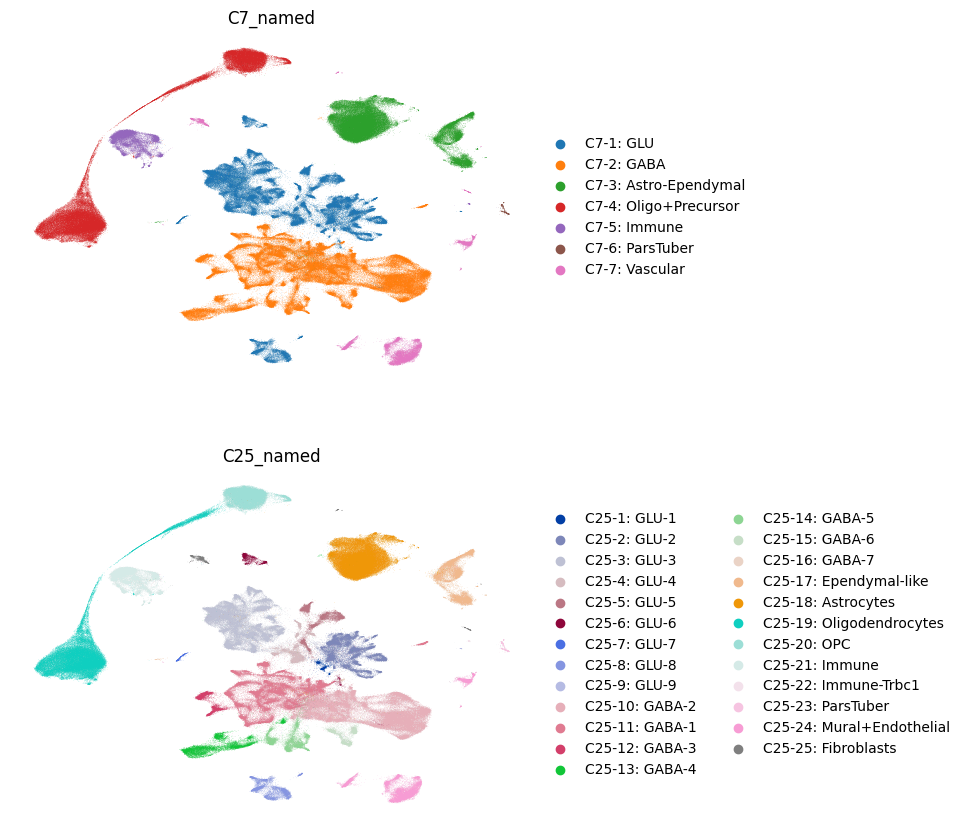

AnnData object with n_obs × n_vars = 384925 × 51811
    obs: 'SRA_ID', 'Sample_ID', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'Dataset', 'Batch_ID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'C7_named', 'C25_named', 'C66_named', 'C185_named', 'C286_named', 'C465_named', 'Author_Class_Curated', 'Author_CellType', 'Region_summarized', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'celltype', 'batch'
    var: 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'batch_condition', 'schema_version', 'title', 'C7_named_colors', 'C25_named_colors'
    obsm: 'X_umap'

In [4]:
hypomap_reference = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/hypomap.h5ad"

# load the reference anndata
adata_ref = sc.read(hypomap_reference)

adata_ref = adata_ref.raw.to_adata() # recover raw counts

# assign the celltype from the cluster 25 column
adata_ref.obs["celltype"] = adata_ref.obs['C25_named'] # note that there are other cluster results in .obs
adata_ref.obs["batch"] = 'reference'
adata_ref.var_names = adata_ref.var['feature_name'] # set gene names as column headers

# plot the UMAP
sc.pl.umap(
    adata_ref,
    color=["C7_named", 'C25_named'],
    frameon=False,
    ncols=1,
)

adata_ref

In [5]:
adata_ref.obs.columns

Index(['SRA_ID', 'Sample_ID', 'organism_ontology_term_id', 'donor_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id',
       'tissue_ontology_term_id', 'cell_type_ontology_term_id',
       'assay_ontology_term_id', 'suspension_type', 'Dataset', 'Batch_ID',
       'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'C7_named', 'C25_named',
       'C66_named', 'C185_named', 'C286_named', 'C465_named',
       'Author_Class_Curated', 'Author_CellType', 'Region_summarized',
       'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage', 'celltype',
       'batch'],
      dtype='object')

In [6]:
# specify or load your anndata / the example
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/h5ad_files/"

test_ref = sc.pp.subsample(adata_ref, n_obs=10000, copy=True)

data = {
    # 'reference' : adata_ref
    # 'reference' : test_ref
}

for f in os.listdir(dirpath):
    fullpath = f"{dirpath}{f}"
    key = f.replace(".h5ad", "")

    batch_andata = sc.read(fullpath)
    batch_andata.obs['batch'] = key
    batch_andata.obs["celltype"] = 'Unknown'
    data[key] = batch_andata
    
    break
    
adata = ad.concat(data, index_unique="_") # combine all the experiments

""" Some minor processing """
adata.layers["counts"] = adata.X.copy() # store the raw counts

sc.pp.calculate_qc_metrics(adata)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)

print('done preprocessing')
# sc.pp.combat(adata) # regress out batch effects

adata.layers["processed_counts"] = adata.X.copy() # store the raw counts. Note: we have to "hide" them from the model later

adata.raw = adata

adata

/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


done preprocessing


AnnData object with n_obs × n_vars = 10261 × 24736
    obs: 'batch', 'celltype'
    var: 'n_cells'
    layers: 'counts', 'processed_counts'

/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/cstansbu/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/cstansbu/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /home/cstansbu/.local/lib/python3.9/site-packages ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cstansbu/.lo

Epoch 10/10: 100%|██████████| 10/10 [03:50<00:00, 23.09s/it, v_num=1, train_loss_step=6.93e+3, train_loss_epoch=6.45e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [03:50<00:00, 23.09s/it, v_num=1, train_loss_step=6.93e+3, train_loss_epoch=6.45e+3]


2023-09-07 15:38:22.880157: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-07 15:38:23.651375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-07 15:38:23.651463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-07 15:38:23.651472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/home/cstansbu/.local/lib/python3.9/site-packages/scanpy/plotti

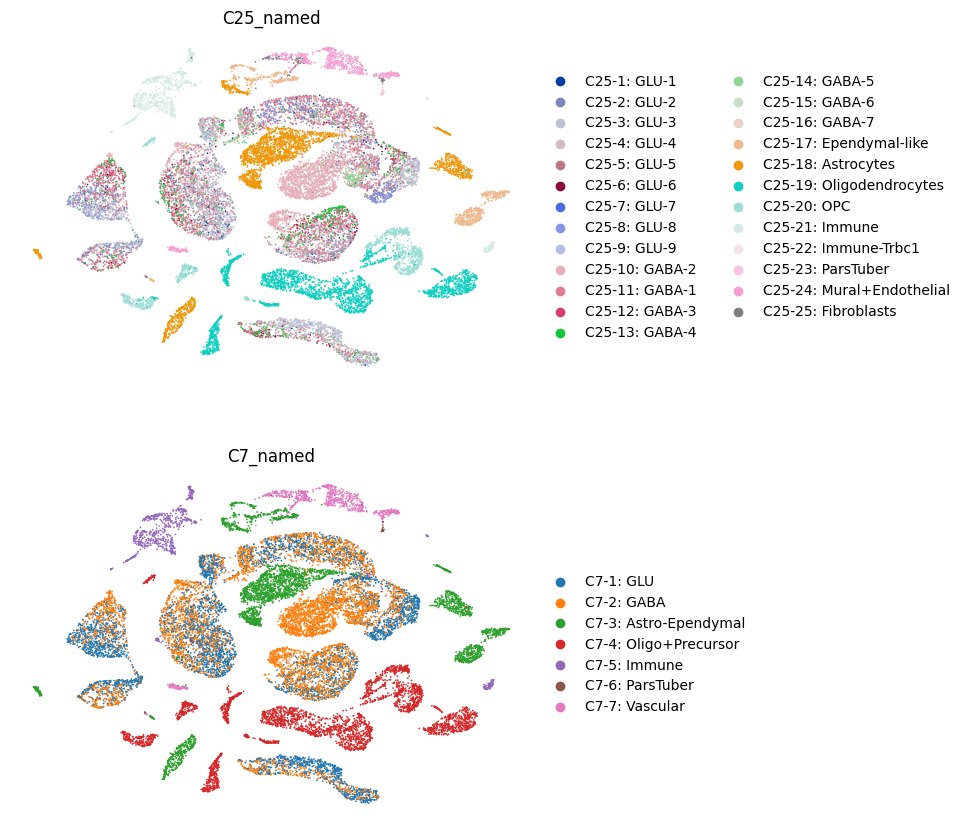

In [7]:
""" Determine a reference embedding """

test_ref = sc.pp.subsample(adata_ref, n_obs=20000, copy=True)
test_ref.layers["counts"] = test_ref.X.copy() # store the raw counts

scvi.model.SCVI.setup_anndata(test_ref, 
                              layer="counts", 
                              batch_key="batch")

ref_model = scvi.model.SCVI(test_ref, 
                        n_latent=30,
                        use_layer_norm="both",
                        use_batch_norm="none",
                        encode_covariates=True,
                        dropout_rate=0.2,
                        n_layers=2,)


max_epochs = 10
ref_model.train(max_epochs=max_epochs)


SCVI_LATENT_KEY = "X_scVI"
test_ref.obsm[SCVI_LATENT_KEY] = ref_model.get_latent_representation()

sc.pp.neighbors(test_ref, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(test_ref)

sc.pl.umap(
    test_ref,
    color=["C25_named", 'C7_named'],
    frameon=False,
    ncols=1,
)

In [8]:
celltype_model = scvi.model.SCANVI.from_scvi_model(
    ref_model,
    unlabeled_category="Unknown",
    labels_key='celltype',
)

celltype_model.train(max_epochs=max_epochs, 
                     n_samples_per_label=100)

INFO     Training for 10 epochs.                                                                                   


/home/cstansbu/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /home/cstansbu/.local/lib/python3.9/site-packages ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cstansbu/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /home/cstansbu/.local/lib/python3.9/site-packages ...
  rank_zero_warn(


Epoch 10/10: 100%|██████████| 10/10 [04:18<00:00, 25.79s/it, v_num=1, train_loss_step=6.28e+3, train_loss_epoch=6.42e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [04:18<00:00, 25.85s/it, v_num=1, train_loss_step=6.28e+3, train_loss_epoch=6.42e+3]


In [9]:
scvi.model.SCANVI.prepare_query_anndata(adata, celltype_model)
transfer_model = scvi.model.SCANVI.load_query_data(adata, celltype_model)

INFO     Found 47.03055335739515% reference vars in query data.                                                    


/tmp/ipykernel_367280/2729994449.py:1: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  scvi.model.SCANVI.prepare_query_anndata(adata, celltype_model)
/home/cstansbu/.local/lib/python3.9/site-packages/scvi/model/base/_archesmixin.py:225: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(
/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/cstansbu/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM,

In [10]:
transfer_model.train(
    max_epochs=max_epochs,
    plan_kwargs={"weight_decay": 0.0},
)

INFO     Training for 10 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cstansbu/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.9 /home/cstansbu/.local/lib/python3.9/site-packages ...
  rank_zero_warn(


Epoch 10/10: 100%|██████████| 10/10 [01:36<00:00,  9.64s/it, v_num=1, train_loss_step=9.59e+3, train_loss_epoch=1.06e+4]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [01:36<00:00,  9.64s/it, v_num=1, train_loss_step=9.59e+3, train_loss_epoch=1.06e+4]


In [11]:
adata.obsm['learned_embedding'] = transfer_model.get_latent_representation()
adata.obs['predicted_celltype'] = transfer_model.predict()

adata.obs['predicted_celltype'].value_counts()

C25-2: GLU-2                 3623
C25-5: GLU-5                 2179
C25-3: GLU-3                 1600
C25-8: GLU-8                 1016
C25-19: Oligodendrocytes      809
C25-18: Astrocytes            342
C25-20: OPC                   166
C25-21: Immune                163
C25-6: GLU-6                   98
C25-17: Ependymal-like         95
C25-14: GABA-5                 77
C25-24: Mural+Endothelial      29
C25-15: GABA-6                 26
C25-10: GABA-2                 25
C25-25: Fibroblasts            13
Name: predicted_celltype, dtype: int64

In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# """ prepare the query """

# scvi.model.SCVI.prepare_query_anndata(adata, ref_model)

# model = scvi.model.SCVI.load_query_data(
#     adata,
#     ref_model,
# )

# max_epochs=2
# model.train(max_epochs=max_epochs, 
#             plan_kwargs={"weight_decay": 0.0})

# print('done')

In [ ]:
# """ use the model to predict labels """

# all_data = adata.concatenate(test_ref)

# scvi.model.SCVI.setup_anndata(all_data, 
#                               layer="counts", 
#                               batch_key="batch")

# scanvi_model = scvi.model.SCANVI.from_scvi_model(
#     model,
#     adata=all_data,
#     labels_key="celltype",
#     unlabeled_category="Unknown",
# )

# scanvi_model.train(max_epochs=max_epochs, 
#                    n_samples_per_label=100)

# print('done')

In [ ]:
# break

In [ ]:
# """ Determine a combined embedding """
# scvi.model.SCVI.setup_anndata(adata, 
#                               layer="counts", 
#                               batch_key="batch")

# model = scvi.model.SCVI(adata, 
#                         n_layers=1, 
#                         n_latent=30)

# max_epochs = 2
# model.train(max_epochs=max_epochs)

# model

# SCVI_LATENT_KEY = "X_scVI"
# adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

# sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
# sc.tl.leiden(adata)
# sc.tl.umap(adata)

# sc.pl.umap(
#     adata,
#     color=["batch", "leiden"],
#     frameon=False,
#     ncols=1,
# )

In [ ]:
break

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="celltype",
    unlabeled_category="Unknown",
)

scanvi_model.train(max_epochs=max_epochs, 
                   n_samples_per_label=100)

print('done')

In [ ]:
SCANVI_LATENT_KEY = "X_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs['predicted_celltype'] = scanvi_model.predict(adata)

In [ ]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.leiden(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

In [ ]:
def get_predictions(adata):
    """A function to return the predicted cell types for our data"""
    df = adata.obs.copy()
    df = df[df['batch'] != 'reference']
    df = df.reset_index(drop=False)
    return df


pred = get_predictions(adata)
pred.head()

In [ ]:
our_cells = adata.obs[adata.obs['batch'] != 'reference']
our_cells['predicted_celltype'].value_counts()

In [ ]:
?scanvi_model.train

In [ ]:
break

In [ ]:
break

In [ ]:
""" Load the model """
# model_path = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/model"

# prepare query data
# scvi.model.SCVI.prepare_query_anndata(adata, model_path, inplace=True)

# # concatenate
# adata = adata.concatenate(adata_hypomap)
# adata

In [ ]:
# """ Load the model """
# model_path = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/model"

# # prepare query data
# scvi.model.SCVI.prepare_query_anndata(adata_query, model_path)

# # create the new query model instance.
# vae = scvi.model.SCVI.load_query_data(
#     adata_query,
#     model_path,
# )

# # embed our data in the hypoMap space
# vae.train(max_epochs=20, plan_kwargs=dict(weight_decay=0.0))

# # save the hypoMap embedding
# adata_query.obsm["X_scVI"] = vae.get_latent_representation()

# print('done')

In [ ]:
# ## calculate UMAP based on hypoMAP:
# sc.pp.neighbors(adata_query, use_rep="X_scVI")
# sc.tl.leiden(adata_query)
# sc.tl.umap(adata_query)

# sc.pl.umap(
#     adata_query,
#     color=["leiden"],
#     # color=["C25_named"],
#     frameon=False,
#     ncols=1,
# )

In [ ]:
# adata_hypomap.obs.columns

# adata_hypomap.obs[['C7_named', 'C25_named', 'C66_named']].head()